In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import seaborn as sns

# change the data file as needed
df = pd.read_csv('WSE/WSE_2022.csv', parse_dates=['Date_Time'])
# only keep 'Date_Time' column and the specific piezometer of interest
df = df[['Date_Time', 'P2C']]
# rename the columns
df.columns = ['Time', 'Elevation']
# keep only spring dates
df = df[(df['Time'].dt.month >= 3) & (df['Time'].dt.month <= 5)]
df


,Time,Elevation
0,2022-03-01 00:00:00,2723.121248
1,2022-03-01 00:15:00,2723.121831
2,2022-03-01 00:30:00,2723.123387
3,2022-03-01 00:45:00,2723.148079
4,2022-03-01 01:00:00,2723.135243
...,...,...
6380,2022-05-06 11:00:00,2723.116583
6381,2022-05-06 11:15:00,2723.116583
6382,2022-05-06 11:30:00,2723.116583
6383,2022-05-06 11:45:00,2723.116583


In [20]:
# Remove all values below an elevation of 2737.27
df['Elevation'] = df['Elevation'].apply(lambda x: x if x > 2723.09 else np.nan)

# Calculate rolling statistics
window_size = 70  # e.g., using a 3-hour window (12 * 15 min intervals)
df['Rolling_Mean'] = df['Elevation'].rolling(window=window_size, center=True).mean()
df['Rolling_Std'] = df['Elevation'].rolling(window=window_size, center=True).std()

# Define an outlier as any value > 3 standard deviations from the rolling mean
threshold = 3
df['Outlier'] = (df['Elevation'] - df['Rolling_Mean']).abs() > (threshold * df['Rolling_Std'])

# Remove outliers by interpolating (or you can set them to NaN)
df.loc[df['Outlier'], 'Elevation'] = np.nan
df['Elevation'] = df['Elevation'].interpolate()

# Smooth the data using a moving average
df['Smoothed'] = df['Elevation'].rolling(window=30, center=True).mean()

# Alternatively, use Savitzky-Golay filter for smoothing
df['Smoothed_SG'] = savgol_filter(df['Elevation'], window_length=30, polyorder=2)

# Drop unnecessary columns
df = df.drop(columns=['Rolling_Mean', 'Rolling_Std', 'Outlier'])

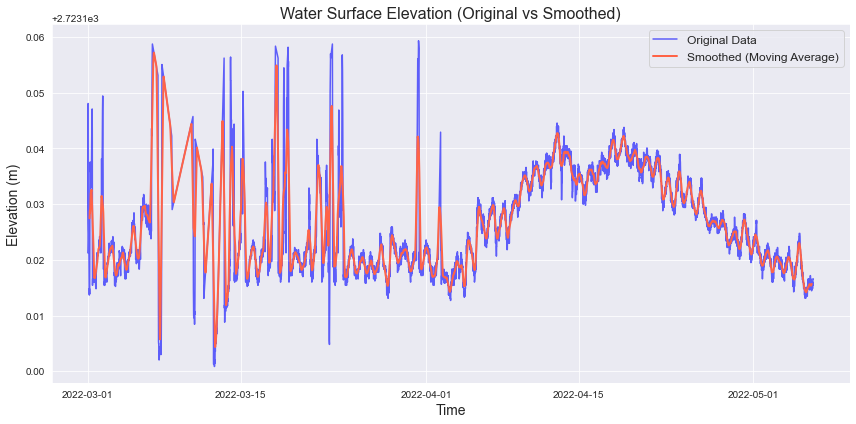

In [22]:
# Plotting
sns.set_style('darkgrid')
plt.figure(figsize=(12, 6))

# Plot original data
plt.plot(df['Time'], df['Elevation'], label='Original Data', color='blue', alpha=0.6, linestyle='-')

# Plot smoothed data (moving average)
plt.plot(df['Time'], df['Smoothed'], label='Smoothed (Moving Average)', color='tomato', linewidth=2)

# Plot smoothed data (Savitzky-Golay)
#plt.plot(df['Time'], df['Smoothed_SG'], label='Smoothed (Savitzky-Golay)', color='yellowgreen', linewidth=2)

# Enhancing the plot with titles and labels
plt.title('Water Surface Elevation (Original vs Smoothed)', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Elevation (m)', fontsize=14)
plt.legend(loc='best', fontsize=12)

# Adding grid and adjusting layout
plt.grid(True)
plt.tight_layout()

# Display the plot
plt.show()